# Librerias

In [12]:
import pandas as pd
import numpy as np
import tensorflow
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
'''
Lectura de datos de restaurantes de Madrid.
'''
restaurantes = pd.read_csv('../data/processed/restaurantes.csv')

In [14]:
restaurantes.drop(['nombre_restaurante', 'place_id',
                   'direccion', 'tipo_cocina',
                   'rating', 'user_ratings_total'
                   ], inplace=True, axis=1) # Quitamos columnas de texto

In [15]:
X = restaurantes.drop('y', axis=1)

y = restaurantes['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_scale = scalar.fit_transform(X_train)

In [16]:
pca_full = PCA()
pca_full.fit(X_scale)
varianza_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

In [17]:
n_components_90 = np.argmax(varianza_acumulada >= 0.90) + 1
print(n_components_90)

104


In [18]:
pca = PCA(n_components=n_components_90)
X_pca = pca.fit_transform(X_scale)

In [19]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(n_components_90,),
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
])

model.compile(
    loss="mean_squared_error",
    optimizer=tensorflow.keras.optimizers.RMSprop(0.001),
    metrics=['mae', 'mse']
)

c:\Users\karli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,833 (34.50 KB)

 Trainable params: 8,833 (34.50 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_pca,
                   y_train,
                   epochs=60,
                   validation_split= 0.2,
                   callbacks = [early_stopping_cb])

Epoch 1/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 559.1553 - mae: 22.1322 - mse: 559.0322 - val_loss: 253.9021 - val_mae: 14.3433 - val_mse: 253.7681
Epoch 2/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 191.0061 - mae: 12.1161 - mse: 190.8676 - val_loss: 82.5750 - val_mae: 7.5400 - val_mse: 82.4276
Epoch 3/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 102.0657 - mae: 7.8352 - mse: 101.9173 - val_loss: 68.7012 - val_mae: 6.7640 - val_mse: 68.5523
Epoch 4/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 77.2058 - mae: 6.9135 - mse: 77.0565 - val_loss: 64.1124 - val_mae: 6.4976 - val_mse: 63.9631
Epoch 5/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 75.4317 - mae: 7.0699 - mse: 75.2821 - val_loss: 61.5271 - val_mae: 6.2872 - val_mse: 61.3774
Epoch 6/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 68.1319 - mae: 6.5646 - mse: 67.9820 - val_loss: 60.8842 - val_mae: 6.2325 - val_mse: 60.7344
Epoch 7/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 66.6537 - mae: 6.60

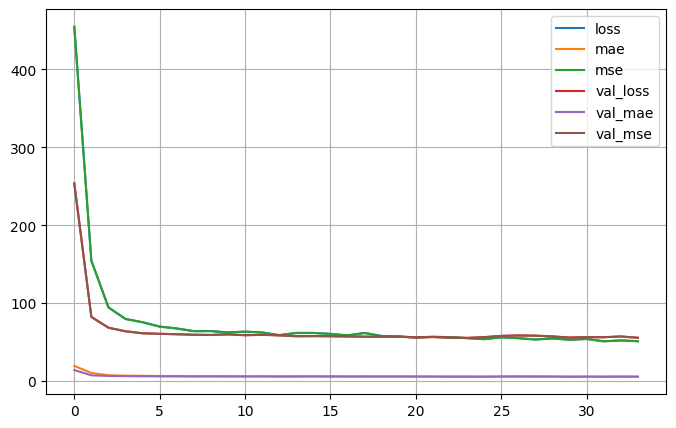

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

plt.show()

In [23]:
mse_test = model.evaluate(pca.transform(scalar.transform(X_test)), y_test)
print(mse_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48.2039 - mae: 5.4588 - mse: 48.0580 
[46.71841049194336, 5.370798587799072, 46.57252883911133]


In [24]:
y_pred = model.predict(pca.transform(scalar.transform(X_test)))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


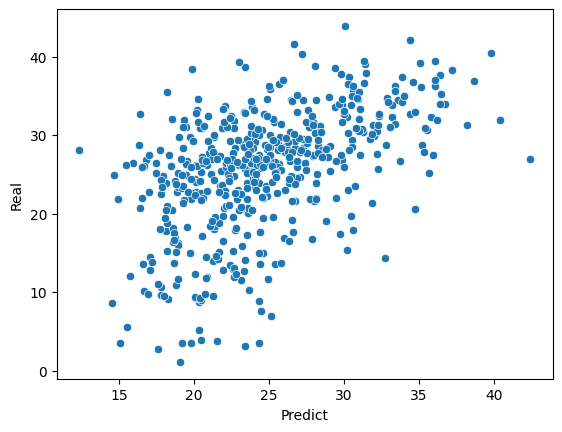

In [25]:
sns.scatterplot(x=y_pred[:, 0], y=y_test)
plt.xlabel('Predict')
plt.ylabel('Real')
plt.show()

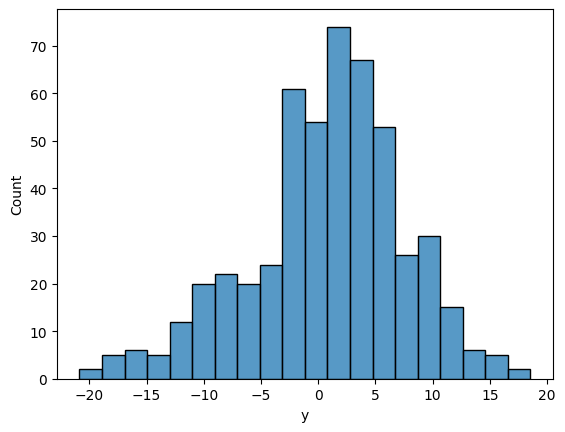

In [26]:
sns.histplot(y_test-y_pred[:, 0]);

In [27]:
model.save("../models/7_redneuronal_model.keras")